In [ ]:
import torch
from string import punctuation
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.lm import Vocabulary
from nltk import pos_tag
import spacy
import pandas as pd
import numpy as np
import string
from sklearn.preprocessing import OneHotEncoder
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
spacy.load('en_core_web_sm')

# Data Analysis and Preprocessing

In [ ]:
!unzip liar_dataset.zip

Archive:  liar_dataset.zip
  inflating: README                  
  inflating: test.tsv                
  inflating: train.tsv               
  inflating: valid.tsv               


In [ ]:
dataset_columns = ['id','label','text','subject','speaker','job title','state info','party','barely true','false','half true','mostly true','pants on fire','context']

In [ ]:
train = pd.read_csv('train.tsv',sep='\t',header=None, names = dataset_columns)
test = pd.read_csv('test.tsv',sep='\t',header=None, names = dataset_columns)
val = pd.read_csv('valid.tsv',sep='\t',header=None, names = dataset_columns)

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10240 non-null  object 
 1   label          10240 non-null  object 
 2   text           10240 non-null  object 
 3   subject        10238 non-null  object 
 4   speaker        10238 non-null  object 
 5   job title      7343 non-null   object 
 6   state info     8032 non-null   object 
 7   party          10238 non-null  object 
 8   barely true    10238 non-null  float64
 9   false          10238 non-null  float64
 10  half true      10238 non-null  float64
 11  mostly true    10238 non-null  float64
 12  pants on fire  10238 non-null  float64
 13  context        10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
None


In [ ]:
print(train.head(2))

           id      label                                               text  \
0   2635.json      false  Says the Annies List political group supports ...   
1  10540.json  half-true  When did the decline of coal start? It started...   

                              subject         speaker             job title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   

  state info       party  barely true  false  half true  mostly true  \
0      Texas  republican          0.0    1.0        0.0          0.0   
1   Virginia    democrat          0.0    0.0        1.0          1.0   

   pants on fire          context  
0            0.0         a mailer  
1            0.0  a floor speech.  


In [ ]:
# number of rows with nas in it
print(train.isna().sum())

# too many rows (~20% of the dataset), removing these might cause issues
# we might need to add in another class called unknown for nan values in
# job title and state info. This was preferred so thatwe can keep the data
# without adding bias using imputation through median values or inverse cosine

# other columns are small enough that the rows can be dropped and ignored

id                  0
label               0
text                0
subject             2
speaker             2
job title        2897
state info       2208
party               2
barely true         2
false               2
half true           2
mostly true         2
pants on fire       2
context           102
dtype: int64


In [ ]:
def handle_nas(df):
  # get all indices where job title and state info are nas:
  jt_indices = df[df["job title"].isna()].index
  si_indices = df[df["state info"].isna()].index

  df.loc[jt_indices,"job title"] = "unk"
  df.loc[si_indices,"state info"] = "unk"

  # dropping all other rows with nas
  df.dropna(inplace=True)
  df = df.reset_index(drop=True)

  return df


In [ ]:
train = handle_nas(train)
print(train.isna().sum())
print(train.info())

id               0
label            0
text             0
subject          0
speaker          0
job title        0
state info       0
party            0
barely true      0
false            0
half true        0
mostly true      0
pants on fire    0
context          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10138 entries, 0 to 10137
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10138 non-null  object 
 1   label          10138 non-null  object 
 2   text           10138 non-null  object 
 3   subject        10138 non-null  object 
 4   speaker        10138 non-null  object 
 5   job title      10138 non-null  object 
 6   state info     10138 non-null  object 
 7   party          10138 non-null  object 
 8   barely true    10138 non-null  float64
 9   false          10138 non-null  float64
 10  half true      10138 non-null  float64
 11  mostly true    10138 non-null  floa

In [ ]:
test = handle_nas(test)
val = handle_nas(val)

In [ ]:
def get_meta_data(df, df_val, df_test):
  concatenated_df = pd.concat([df,df_val,df_test])
  print(concatenated_df)
  # handling meta data
  # not storing anything in vocab
  top_categories = df['speaker'].value_counts().nlargest(20).index
  print("speaker top categories:",df['speaker'].value_counts().nlargest(20))
  concatenated_df['speaker'] = concatenated_df['speaker'].where(concatenated_df['speaker'].isin(top_categories), 'Other')
  speaker_ohe = pd.get_dummies(concatenated_df['speaker']).to_numpy()
  print(speaker_ohe.shape)

  # largest category is unk which we imputed. To ensure there is no bias, it is
  # not taken into consideration
  top_categories = df['job title'].value_counts().nlargest(20).index
  print("job title top categories:",df['job title'].value_counts().nlargest(20))
  concatenated_df['job title'] = concatenated_df['job title'].where(concatenated_df['job title'].isin(top_categories), 'Other')
  job_title_ohe = pd.get_dummies(concatenated_df['job title']).to_numpy()
  print(job_title_ohe.shape)

  # largest category is unk which we imputed. To ensure there is no bias, it is
  # not taken into consideration
  top_categories = df['state info'].value_counts().nlargest(20).index
  print("state info top categories:",df['state info'].value_counts().nlargest(20))
  concatenated_df['state info'] = concatenated_df['state info'].where(concatenated_df['state info'].isin(top_categories), 'Other')
  state_info_ohe = pd.get_dummies(concatenated_df['state info']).to_numpy()
  print(state_info_ohe.shape)

  top_categories = df['party'].value_counts().nlargest(20).index
  print("party top categories:",df['party'].value_counts().nlargest(20))
  concatenated_df['party'] = concatenated_df['party'].where(concatenated_df['party'].isin(top_categories), 'Other')
  party_ohe = pd.get_dummies(concatenated_df['party']).to_numpy()
  print(party_ohe.shape)


  top_categories = (
      df['subject'].str.split(',', expand=True).stack()
      .value_counts().nlargest(20).index
  )

  subjects = concatenated_df['subject'].apply(lambda x: [cat for cat in x.split(',') if cat in top_categories])
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)
  print("subjects top categories:",subjects.columns)
  subject_ohe = subjects.to_numpy()
  print(subject_ohe.shape)

  counts = concatenated_df[['barely true','false','half true','mostly true','pants on fire']].to_numpy()
  print(counts.shape)

  meta_data = np.hstack((speaker_ohe,job_title_ohe,state_info_ohe,party_ohe,counts))
  meta_data_train = meta_data[:len(df)]
  meta_data_val = meta_data[len(df):len(df)+len(df_val)]
  meta_data_test = meta_data[len(df)+len(df_val):]
  print(meta_data.shape)

  return meta_data_train,meta_data_val,meta_data_test


In [ ]:
meta_data_train,meta_data_val,meta_data_test = get_meta_data(train,val,test)
print(meta_data_train.shape,len(train))
print(meta_data_val.shape,len(val))
print(meta_data_test.shape,len(test))

              id        label  \
0      2635.json        false   
1     10540.json    half-true   
2       324.json  mostly-true   
3      1123.json        false   
4      9028.json    half-true   
...          ...          ...   
1245   7334.json    half-true   
1246   9788.json  barely-true   
1247  10710.json  barely-true   
1248   3186.json  barely-true   
1249   6743.json        false   

                                                   text  \
0     Says the Annies List political group supports ...   
1     When did the decline of coal start? It started...   
2     Hillary Clinton agrees with John McCain "by vo...   
3     Health care reform legislation is likely to ma...   
4     The economic turnaround started at the end of ...   
...                                                 ...   
1245  Says his budget provides the highest state fun...   
1246                    Ive been here almost every day.   
1247  In the early 1980s, Sen. Edward Kennedy secret...   
1248  Says an

<ipython-input-18-4714610db26b>:41: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)


subjects top categories: Index(['candidates-biography', 'crime', 'economy', 'education', 'elections',
       'energy', 'environment', 'federal-budget', 'foreign-policy', 'guns',
       'health-care', 'history', 'immigration', 'job-accomplishments', 'jobs',
       'legal-issues', 'military', 'state-budget', 'taxes', 'workers'],
      dtype='object')
(8305, 20)
(12660, 5)
(12660, 89)
(10138, 89) 10138
(1272, 89) 1272
(1250, 89) 1250


<ipython-input-18-4714610db26b>:41: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  subjects = pd.get_dummies(subjects.apply(pd.Series).stack()).sum(level=0)


In [ ]:

one_hot_encoder = OneHotEncoder()
train_labels = one_hot_encoder.fit_transform(np.array(train["label"]).reshape(-1, 1)).todense()
test_labels = one_hot_encoder.transform(np.array(test["label"]).reshape(-1, 1)).todense()
val_labels = one_hot_encoder.transform(np.array(val["label"]).reshape(-1, 1)).todense()

class LiarDataset(torch.utils.data.Dataset):
  def __init__(self,data,meta_data,all_labels = True, vocab = None, POS_vocab = None, DEP_vocab = None, build_vocab = True):
    self.data = data
    self.all_labels = all_labels
    # get labels
    if self.all_labels == True:
      self.labels = one_hot_encoder.fit_transform(np.array(self.data["label"]).reshape(-1,1)).todense()
    self.stopwords = nltk.corpus.stopwords.words("english")
    self.lemmatizer = nltk.stem.WordNetLemmatizer()
    # TODO: do all_labels = False
    self.vocab = vocab
    self.POS_vocab = POS_vocab
    self.build_vocab = build_vocab
    self.nlp = spacy.load("en_core_web_sm")
    self.tokenizer = get_tokenizer('basic_english')
    self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.max_len = 50
    self.meta_data = meta_data

  def __getitem__(self,idx):
    s = self.data["text"][idx]
    s = s.lower()
    # dep_graph = self.nlp(s)
    s = ''.join([c for c in s if c not in string.punctuation])
    # tokenize text
    s = nltk.word_tokenize(s)
    # remove stop words
    s = [word for word in s if word not in self.stopwords]
    pos = pos_tag(s)
    pos = [tup[1] for tup in pos]
    # perform lemmatization
    s = [self.lemmatizer.lemmatize(word) for word in s]
    s = ' '.join(s)
    # sample = {"Text":s,"POS":pos, "DEP":[token.dep_ for token in dep_graph],"Label":self.labels[idx]}

    # handle meta data



    sample = {"Text":s,"POS":pos,"Meta":self.meta_data[idx],"Label":self.labels[idx]}
    if self.build_vocab == False:
      sample["Text"] = torch.tensor(self.vocab(self.tokenizer(sample["Text"])), dtype=torch.long)
      sample["POS"] = torch.tensor(self.POS_vocab(sample["POS"]), dtype=torch.long)
      sample["Meta"] = torch.tensor(sample["Meta"], dtype=torch.long)
      # sample["DEP"] = torch.tensor(self.DEP_vocab(sample["DEP"]), dtype=torch.long)
      sample = self.preprocessing(sample)
    return sample

  def __len__(self):
    return len(self.data)

  def preprocessing(self,sample):
    if len(sample["Text"]) > self.max_len:
      sample["Text"] = sample["Text"][:self.max_len]
      sample["POS"] = sample["POS"][:self.max_len]
      # sample["DEP"] = sample["DEP"][:self.max_len]
    else:
      sample["Text"] = torch.cat((sample["Text"],torch.tensor([0 for i in range(len(sample["Text"]),self.max_len)])), dim = 0)
      sample["POS"] = torch.cat((sample["POS"],torch.tensor([0 for i in range(len(sample["POS"]),self.max_len)])), dim = 0)
      # sample["DEP"] = torch.cat((sample["DEP"],torch.tensor([0 for i in range(len(sample["DEP"]),self.max_len)])), dim = 0)

    for key in sample:
      if torch.is_tensor(sample[key]):
        sample[key] = sample[key]
      else:
        sample[key] = torch.tensor(sample[key])
    return sample


In [ ]:
train_dataset = LiarDataset(train,meta_data_train)

In [ ]:
tokenizer = get_tokenizer('basic_english')
def get_tokens(data_iter):
  for sample in range(len(data_iter)):
    yield tokenizer(data_iter[sample]["Text"])
vocab = build_vocab_from_iterator(get_tokens(train_dataset), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def get_POS_tokens(data_iter):
  for sample in range(len(data_iter)):
    yield data_iter[sample]["POS"]
POS_vocab = build_vocab_from_iterator(get_POS_tokens(train_dataset), specials=['<unk>'])
POS_vocab.set_default_index(POS_vocab['<unk>'])

# def get_DEP_tokens(data_iter):
#   for sample in range(len(data_iter)):
#     yield data_iter[sample]["DEP"]
# DEP_vocab = build_vocab_from_iterator(get_DEP_tokens(train_dataset), specials=['<unk>'])
# DEP_vocab.set_default_index(DEP_vocab['<unk>'])

print("vocab sizes")
# print("word:",len(vocab),"POS:",len(POS_vocab), "DEP:",len(DEP_vocab))
print("word:",len(vocab),"POS:",len(POS_vocab))

vocab sizes
word: 11742 POS: 35


size of vocab:  11742


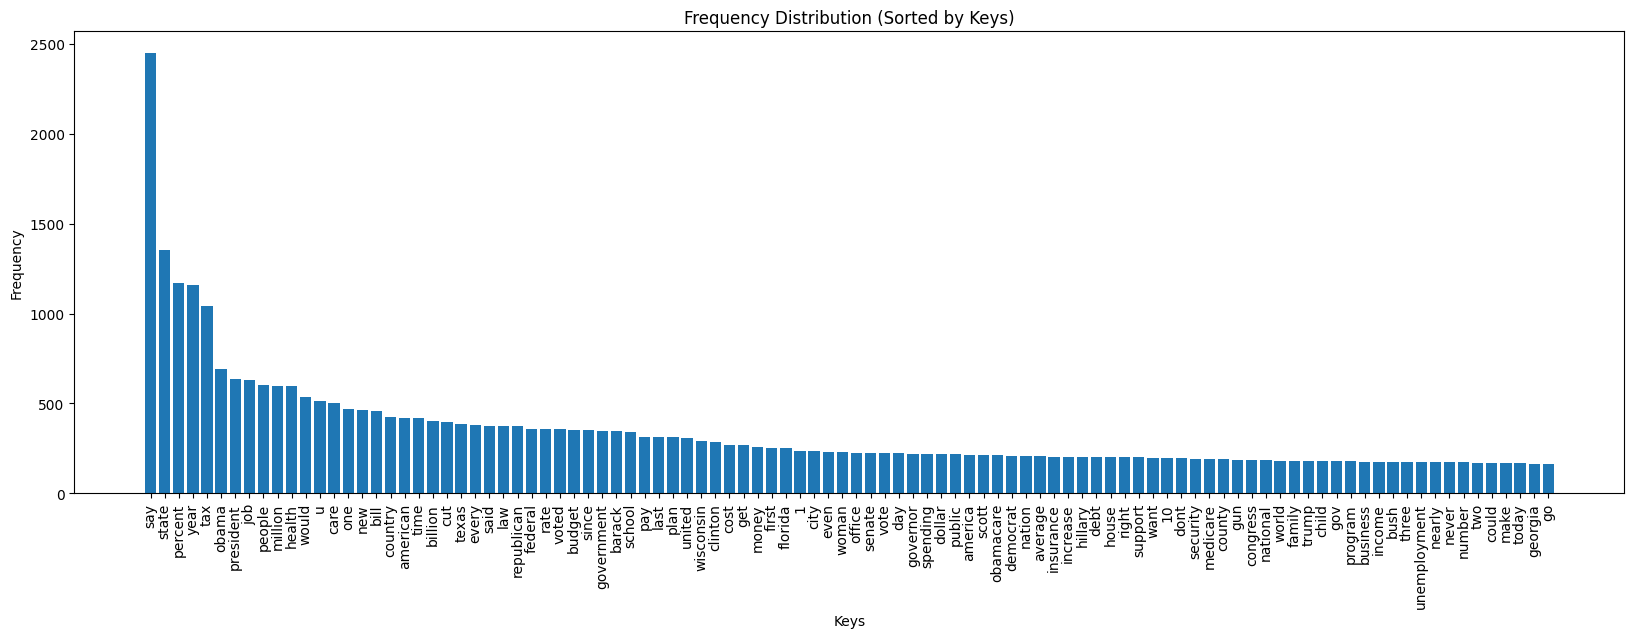

In [ ]:
# understanding vocab
import matplotlib.pyplot as plt
print("size of vocab: ",len(vocab))
train_dataset = LiarDataset(train,meta_data_train, vocab = vocab, build_vocab = True)
freq_dict = {}
for sample in range(len(train_dataset)):
  for word in train_dataset.tokenizer(train_dataset[sample]["Text"]):
    if word not in freq_dict.keys():
      freq_dict[word] = 1
    freq_dict[word] +=1
sorted_frequency_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(20, 6))
plt.bar(list(sorted_frequency_dict.keys())[:100], list(sorted_frequency_dict.values())[:100])
plt.xlabel('Keys')
plt.ylabel('Frequency')
plt.title('Frequency Distribution (Sorted by Keys)')
plt.xticks(rotation=90)
plt.show()
# print(list(freq_dict.keys())[:100], list(freq_dict.values())[:100])

In [ ]:


# getting POS
train_dataset = LiarDataset(train,meta_data_train, vocab = vocab, POS_vocab=POS_vocab,  build_vocab = True)
for sample in range(0,2):
  print("sentence:",train_dataset.tokenizer(train_dataset[sample]["Text"]))
  print("POS tags:",train_dataset[sample]["POS"])
print("\n------------------after vocabulary mapping-------------------\n")
train_dataset = LiarDataset(train,meta_data_train, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)
for sample in range(0,2):
  print("sentence:",train_dataset[sample]["Text"])
  print("POS tags:",train_dataset[sample]["POS"])

sentence: ['say', 'annies', 'list', 'political', 'group', 'support', 'thirdtrimester', 'abortion', 'demand']
POS tags: ['VBZ', 'NNS', 'JJ', 'JJ', 'NN', 'VBZ', 'NN', 'NNS', 'NN']
sentence: ['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bush', 'administration']
POS tags: ['NN', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'VBD', 'VBN', 'NN', 'NN', 'NN', 'VBD', 'JJ', 'NN']

------------------after vocabulary mapping-------------------

sentence: tensor([   1, 6963,  902,  444,  325,   71, 6064,  123, 1435,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
POS tags: tensor([7, 2, 3, 3, 1, 7, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
train_dataset = LiarDataset(train,meta_data_train, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)
test_dataset = LiarDataset(test,meta_data_test, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)
val_dataset = LiarDataset(val,meta_data_val, vocab = vocab, POS_vocab=POS_vocab, build_vocab = False)

In [ ]:

for sample in range(len(train_dataset)):
  print(train_dataset[sample]['Text'])
  print(train_dataset[sample]['POS'])
  print(train_dataset[sample]['Meta'])
  print(train_dataset[sample]['Label'])
  break

tensor([   1, 6963,  902,  444,  325,   71, 6064,  123, 1435,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
tensor([7, 2, 3, 3, 1, 7, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])
tensor([[0., 1., 0., 0., 0., 0.]], dtype=torch.float64)


In [ ]:
def custom_collate(batch):
    texts = [item["Text"] for item in batch]
    POS = [item["POS"] for item in batch]
    meta = [item["Meta"] for item in batch]
    labels = [item["Label"] for item in batch]
    # Convert the list of texts and labels to tensors and stack them
    # text_tensor = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    text_tensor = torch.stack(texts)
    POS_tensor = torch.stack(POS)
    meta_tensor = torch.stack(meta)
    label_tensor = torch.stack(labels)
    return {"Text": text_tensor, "POS": POS_tensor,"Meta": meta_tensor,"Label": label_tensor}


In [ ]:
batch_size = 4
shuffle = True
num_workers = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=custom_collate)